In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [25]:
from io import StringIO

aa = '''iupac\tthree_letter	name
A	Ala	Alanine
C	Cys	Cysteine
D	Asp	Aspartic Acid
E	Glu	Glutamic Acid
F	Phe	Phenylalanine
G	Gly	Glycine
H	His	Histidine
I	Ile	Isoleucine
K	Lys	Lysine
L	Leu	Leucine
M	Met	Methionine
N	Asn	Asparagine
P	Pro	Proline
Q	Gln	Glutamine
R	Arg	Arginine
S	Ser	Serine
T	Thr	Threonine
V	Val	Valine
W	Trp	Tryptophan
Y	Tyr	Tyrosine'''
aa_df = pd.read_csv(StringIO(aa), sep='\t')
aa_df
aminoacids = aa_df['iupac']


In [75]:
mutscores_df = pd.read_csv('results/mutscan_MYL2.tsv', sep='\t')
mutscores_df = mutscores_df.assign(
    wt_residue=lambda df:df['MUTATION'].apply(lambda x: x[0]),
    mut_idx=lambda df:df['MUTATION'].apply(lambda x: int(x[1:-1])),
)
mutscores_df = mutscores_df[(mutscores_df['residue'] != mutscores_df['wt_residue']) & (mutscores_df['residue'].isin(aminoacids))]
mutscores_df.sort_values('score')

,Unnamed: 0,Unnamed: 0.1,GENEINFO,AA_CHANGE,GROUP,MUTATION,GENE,model,residue,sequence_idx,score,wt_residue,mut_idx
774758,2360,17366,MYL2:4633|LOC114827850:114827850,Thr24Ile,VUS,T24I,MYL2,esm1v_t33_650M_UR90S_1,P,37,-22.252377,T,24
320084,2360,17281,MYL2:4633,Val119Ile,VUS,V119I,MYL2,esm1v_t33_650M_UR90S_1,P,37,-22.191042,V,119
276260,2360,17276,MYL2:4633,Arg120Leu,VUS,R120L,MYL2,esm1v_t33_650M_UR90S_1,P,37,-22.128380,R,120
584344,3676,17331,MYL2:4633,Val61Met,VUS,V61M,MYL2,esm1v_t33_650M_UR90S_1,W,25,-22.117178,V,61
232436,2360,17266,MYL2:4633,Glu134Asp,VUS,E134D,MYL2,esm1v_t33_650M_UR90S_1,P,37,-22.088766,E,134
...,...,...,...,...,...,...,...,...,...,...,...,...,...
336917,2759,17286,MYL2:4633,Lys104Glu,VUS,K104E,MYL2,esm1v_t33_650M_UR90S_1,Q,104,8.875925,K,104
554010,732,17326,MYL2:4633,Met69Thr,VUS,M69T,MYL2,esm1v_t33_650M_UR90S_1,L,69,8.965492,M,69
407626,2254,17296,MYL2:4633,Glu97Lys,VUS,E97K,MYL2,esm1v_t33_650M_UR90S_1,D,97,9.200394,E,97
145394,2966,17251,MYL2:4633,Asp145Tyr,VUS,D145Y,MYL2,esm1v_t33_650M_UR90S_1,N,145,9.214523,D,145


In [76]:
mutscores_df['MUTATION'].unique(), mutscores_df['GROUP'].unique()

(array(['D166V', 'E163G', 'G162R', 'I158T', 'Y152D', 'D145Y', 'P144A',
        'F142L', 'E134D', 'A127V', 'R120L', 'V119I', 'K104E', 'A102T',
        'E97K', 'A93E', 'G87A', 'M85I', 'T80N', 'A73D', 'M69T', 'V61M',
        'G57E', 'A54S', 'D48N', 'G42D', 'D37G', 'E28D', 'T24I', 'S19C',
        'N16S', 'G12V', 'G11R', 'K7R', 'M1V'], dtype=object),
 array(['VUS', 'P/LP'], dtype=object))

Text(0.5, 1.0, 'MYL2')

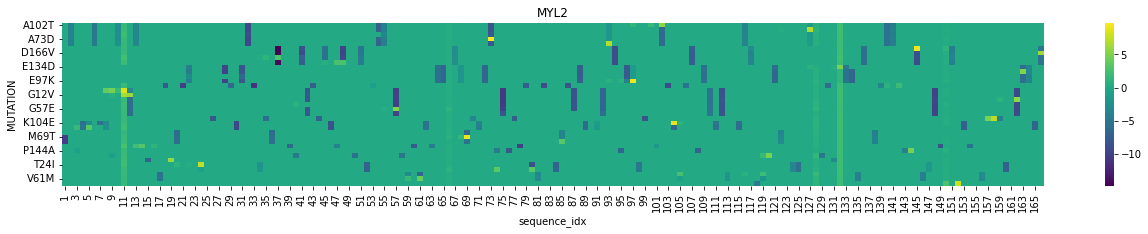

In [77]:
plt.figure(figsize=(22,3))
sns.heatmap(
    data=(mutscores_df
          .sort_values('mut_idx')
          .groupby(['MUTATION', 'sequence_idx'])['score'].max()
          .reset_index()
          .pivot(index='MUTATION', columns='sequence_idx', values='score')
         ),
    cmap='viridis'
)
plt.title(mutscores_df['GENE'].values[0])

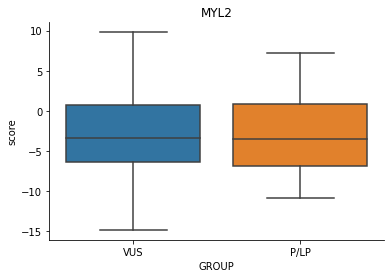

In [78]:
sns.boxplot(
    data=(mutscores_df
          .groupby(['MUTATION', 'GROUP', 'sequence_idx'])['score'].max()
          .reset_index()
          .query('score > 0.01 | score < -0.01')
         ),
    x='GROUP',
    y='score'
)
plt.title(mutscores_df['GENE'].values[0])
sns.despine()